## **MNIST Autoencoder**

**Imports**

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm
from IPython import display

**Parameters**

In [27]:
epochs = 50
batch_size = 128
device = "cuda"

**Load and Preprocess the Dataset**

In [26]:
torch.manual_seed(123) #for dataset reproducibility

train_dataset = DataLoader(
    MNIST("/content/", train=True, transform=transforms.ToTensor(), download=True),
    batch_size=batch_size,
    shuffle=True
)

test_dataset = DataLoader(
    MNIST("/content/", train=False, transform=transforms.ToTensor(), download=True),
    batch_size=batch_size,
    shuffle=True
)

In [28]:
for images, labels in train_dataset:
  print(images.shape)
  break

torch.Size([128, 1, 28, 28])


In [29]:
images.min(), images.max()

(tensor(0.), tensor(1.))

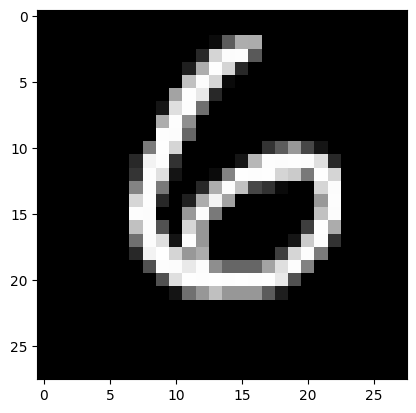

In [30]:
plt.imshow(images[0].permute(1, 2, 0), cmap="gray");

**Build the Model**

In [31]:
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()

    # Encoder
    self.encoder_model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
    )

    # Decoder
    self.decoder_model = nn.Sequential(
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 28*28),
        nn.Sigmoid(), #Pixel values range from 0 (black) to 1 (white)
        nn.Unflatten(1, (1, 28, 28))
    )

  def forward(self, x):
    x = self.encoder_model(x)
    x = self.decoder_model(x)

    return x

In [32]:
torch.manual_seed(123)

encoder_model = Autoencoder().encoder_model.to(device)
autoencoder_model = Autoencoder().to(device)

summary(autoencoder_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 32]           2,080
              ReLU-7                   [-1, 32]               0
            Linear-8                   [-1, 64]           2,112
              ReLU-9                   [-1, 64]               0
           Linear-10                  [-1, 128]           8,320
             ReLU-11                  [-1, 128]               0
           Linear-12                  [-1, 784]         101,136
          Sigmoid-13                  [-1, 784]               0
        Unflatten-14            [-1, 1,

**Train the Model**

In [33]:
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [34]:
def train_autoencoder(epochs=epochs):
  history = {"loss":[], "val_loss":[]}

  for epoch in range(epochs):
    loss_list, val_loss_list = [], []

    with tqdm(train_dataset) as pbar:
      pbar.set_description(f"[Epoch {epoch+1}/{epochs}]")
      for images, _ in pbar:
        images = images.to(device)

        # Update Autoencoder
        optimizer.zero_grad()
        gen_images = autoencoder_model(images)
        loss = criterion(gen_images, images)
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        pbar.set_postfix({"loss": loss.item()})

    loss_mean = np.mean(loss_list)
    history["loss"].append(loss_mean)

    # Calculate test_dataset loss
    with torch.no_grad():
      for images_test, _ in test_dataset:
        images_test = images_test.to(device)
        gen_images_test = autoencoder_model(images_test)
        val_loss = criterion(gen_images_test, images_test)
        val_loss_list.append(val_loss.item())

    val_loss_mean = np.mean(val_loss_list)
    history["val_loss"].append(val_loss_mean)

    # Clean pbar description and postfix
    display.clear_output(wait=True)
    for i in range(epoch+1):
      print(f"[Epoch {i+1:>{len(str(epochs))}}/{epochs}]:   loss: {history['loss'][i]:.4f} - val_loss: {history['val_loss'][i]:.4f}")

  return history

In [35]:
history = train_autoencoder()

[Epoch  1/50]:   loss: 0.2529 - val_loss: 0.1799
[Epoch  2/50]:   loss: 0.1605 - val_loss: 0.1435
[Epoch  3/50]:   loss: 0.1387 - val_loss: 0.1317
[Epoch  4/50]:   loss: 0.1298 - val_loss: 0.1251
[Epoch  5/50]:   loss: 0.1238 - val_loss: 0.1198
[Epoch  6/50]:   loss: 0.1190 - val_loss: 0.1160
[Epoch  7/50]:   loss: 0.1154 - val_loss: 0.1125
[Epoch  8/50]:   loss: 0.1122 - val_loss: 0.1094
[Epoch  9/50]:   loss: 0.1093 - val_loss: 0.1069
[Epoch 10/50]:   loss: 0.1070 - val_loss: 0.1049
[Epoch 11/50]:   loss: 0.1048 - val_loss: 0.1027
[Epoch 12/50]:   loss: 0.1030 - val_loss: 0.1010
[Epoch 13/50]:   loss: 0.1016 - val_loss: 0.0997
[Epoch 14/50]:   loss: 0.1005 - val_loss: 0.0987
[Epoch 15/50]:   loss: 0.0995 - val_loss: 0.0978
[Epoch 16/50]:   loss: 0.0986 - val_loss: 0.0971
[Epoch 17/50]:   loss: 0.0979 - val_loss: 0.0964
[Epoch 18/50]:   loss: 0.0972 - val_loss: 0.0960
[Epoch 19/50]:   loss: 0.0965 - val_loss: 0.0951
[Epoch 20/50]:   loss: 0.0958 - val_loss: 0.0945
[Epoch 21/50]:   los

In [36]:
# Function to plot the losses
def plot_metrics(history, renderer=None, epochs=epochs):
  losses = history["loss"]
  val_losses = history["val_loss"]
  list_epochs = np.arange(1, epochs+1)

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name="Loss", line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name="Val Loss", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text="Loss")
  fig.update_layout(title=f"Evolution of Loss across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [37]:
# Interactive graphic
plot_metrics(history)

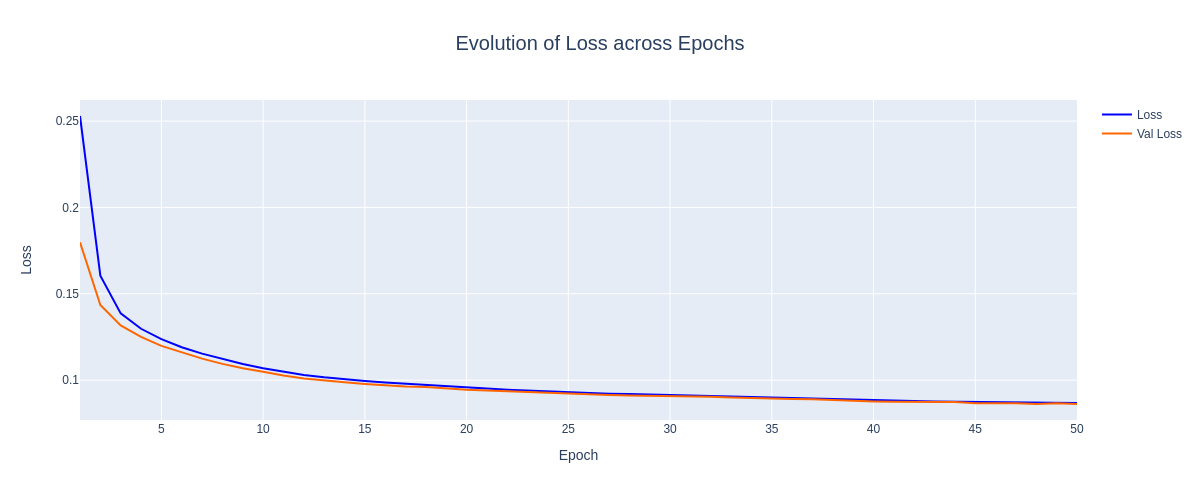

In [39]:
# Image for GitHub
plot_metrics(history, renderer="png")

There is no overfitting observed.

**Test set results**

In [40]:
# Take a batch of test_dataset
for images, _ in test_dataset:
  break

images.shape

torch.Size([128, 1, 28, 28])

In [41]:
# Predictions
images = images.to(device)

latent_rep = encoder_model(images).detach().cpu()
gen_images = autoencoder_model(images).detach().cpu()
images = images.cpu()

latent_rep.shape, gen_images.shape

(torch.Size([128, 32]), torch.Size([128, 1, 28, 28]))

In [42]:
# Reshape
latent_rep = torch.reshape(latent_rep, (-1, 8, 4))

In [43]:
names = ["Images", "Latent Representation", "Generated Images"]

In [44]:
# Function to display images

def show_images(images, latent_rep, gen_images, num_examples=25, names=names, random=True, cmap="gray"):

  indices = np.arange(len(images))
  if random:
    np.random.shuffle(indices)

  fig, ax = plt.subplots(num_examples, 3, figsize=(6, num_examples*2))

  for i in range(num_examples):
    ax[i, 0].imshow(images[indices[i]].permute(1, 2, 0), cmap="gray")
    ax[i, 0].axis("off")

    ax[i, 1].imshow(latent_rep[indices[i]], cmap="gray")
    ax[i, 1].axis("off")

    ax[i, 2].imshow(gen_images[indices[i]].permute(1, 2, 0), cmap="gray")
    ax[i, 2].axis("off")

  ax[0, 0].set_title(names[0], fontsize=8, fontweight="bold")
  ax[0, 1].set_title(names[1], fontsize=8, fontweight="bold")
  ax[0, 2].set_title(names[2], fontsize=8, fontweight="bold")

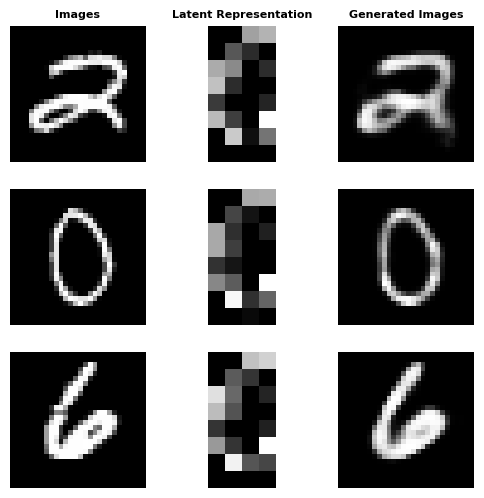

In [45]:
show_images(images, latent_rep, gen_images, random=False, num_examples=3)

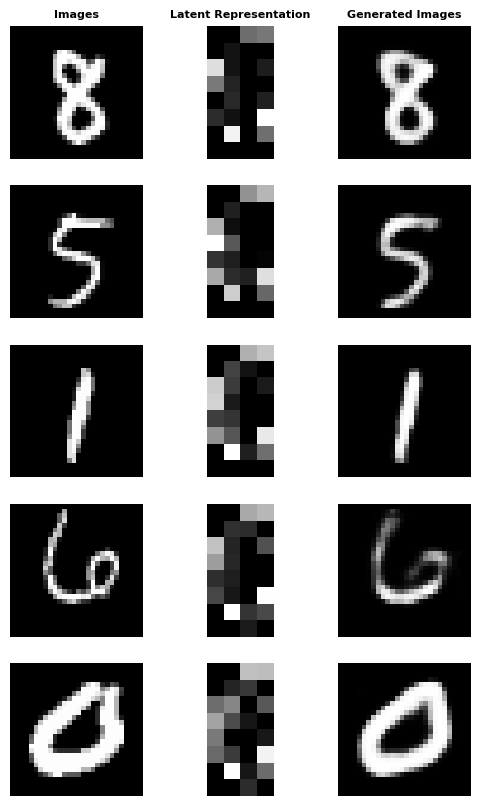

In [49]:
show_images(images, latent_rep, gen_images, num_examples=5)